# Shortcuts Analysis Notebook

This notebook analyzes the final shortcuts table generated by the shortest path computation.

The shortcuts table contains all-pairs shortest paths computed across different H3 resolution levels.

## 1. Setup and Load Data

In [27]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [28]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("ShortcutsAnalysis") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

print(f"Spark version: {spark.version}")

Spark version: 4.0.1


25/11/19 16:22:11 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [29]:
# Load shortcuts data
shortcuts_path = "../output/shortcuts_final"
shortcuts_df = spark.read.parquet(shortcuts_path)

print(f"Total shortcuts: {shortcuts_df.count():,}")
print(f"\nSchema:")
shortcuts_df.printSchema()

Total shortcuts: 2,218,590

Schema:
root
 |-- incoming_edge: string (nullable = true)
 |-- outgoing_edge: string (nullable = true)
 |-- cost: double (nullable = true)
 |-- via_edge: string (nullable = true)



In [30]:
# Show sample data
shortcuts_df.show(10, truncate=False)

+--------------------------+--------------------------+------------------+--------------------------+
|incoming_edge             |outgoing_edge             |cost              |via_edge                  |
+--------------------------+--------------------------+------------------+--------------------------+
|(10026222041, 10026222048)|(12778905421, 12778905426)|23.912151666666666|(10026222041, 10026222048)|
|(10026222041, 10026222048)|(5984609254, 9165939674)  |42.20617666666666 |(10026222048, 10026222041)|
|(10043734702, 10043734703)|(1114576327, 1114576621)  |16.8213           |(10043734702, 10043734703)|
|(10043734702, 10043734703)|(824069722, 1114576375)   |8.77245           |(10043734702, 10043734703)|
|(10044004582, 7937537689) |(852507061, 7056069866)   |12.039746666666666|(10044004582, 7937537689) |
|(10044870706, 10044894622)|(431380665, 7237842088)   |31.364165         |(10044870706, 10044894622)|
|(10044894621, 10222056276)|(11308014616, 978424195)  |16.6233           |(1004489

## 2. Basic Statistics

In [31]:
# Cost statistics
cost_stats = shortcuts_df.select(
    F.count("*").alias("total_paths"),
    F.min("cost").alias("min_cost"),
    F.max("cost").alias("max_cost"),
    F.avg("cost").alias("avg_cost"),
    F.stddev("cost").alias("stddev_cost"),
    F.expr("percentile_approx(cost, 0.5)").alias("median_cost"),
    F.expr("percentile_approx(cost, 0.95)").alias("p95_cost")
).toPandas()

print("Cost Statistics (in seconds):")
print("=" * 60)
for col in cost_stats.columns:
    value = cost_stats[col].iloc[0]
    if col == 'total_paths':
        print(f"{col:.<30} {value:,.0f}")
    else:
        print(f"{col:.<30} {value:.2f} sec ({value/60:.2f} min)")

Cost Statistics (in seconds):
total_paths................... 2,218,590
min_cost...................... 0.01 sec (0.00 min)
max_cost...................... 405.12 sec (6.75 min)
avg_cost...................... 46.94 sec (0.78 min)
stddev_cost................... 48.34 sec (0.81 min)
median_cost................... 30.64 sec (0.51 min)
p95_cost...................... 150.03 sec (2.50 min)


In [32]:
# Count unique edges
unique_incoming = shortcuts_df.select("incoming_edge").distinct().count()
unique_outgoing = shortcuts_df.select("outgoing_edge").distinct().count()
unique_via = shortcuts_df.select("via_edge").distinct().count()

print(f"Unique incoming edges: {unique_incoming:,}")
print(f"Unique outgoing edges: {unique_outgoing:,}")
print(f"Unique via edges: {unique_via:,}")

Unique incoming edges: 34,751
Unique outgoing edges: 34,759
Unique via edges: 34,752


## 3. Cost Distribution Analysis

In [33]:
# Sample data for visualization (to avoid memory issues)
sample_fraction = 0.01  # 1% sample
shortcuts_sample = shortcuts_df.sample(fraction=sample_fraction, seed=42).toPandas()

print(f"Sample size: {len(shortcuts_sample):,} rows ({sample_fraction*100}% of total)")

Sample size: 22,344 rows (1.0% of total)


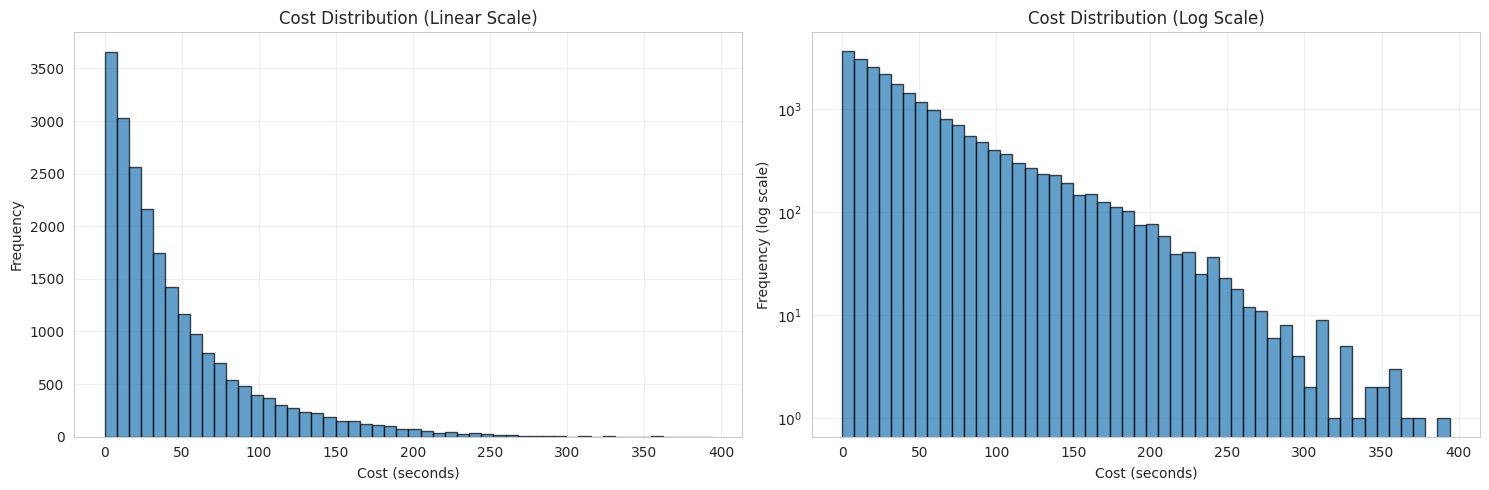

In [34]:
# Cost distribution histogram
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Linear scale
axes[0].hist(shortcuts_sample['cost'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Cost (seconds)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Cost Distribution (Linear Scale)')
axes[0].grid(True, alpha=0.3)

# Log scale
axes[1].hist(shortcuts_sample['cost'], bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Cost (seconds)')
axes[1].set_ylabel('Frequency (log scale)')
axes[1].set_title('Cost Distribution (Log Scale)')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

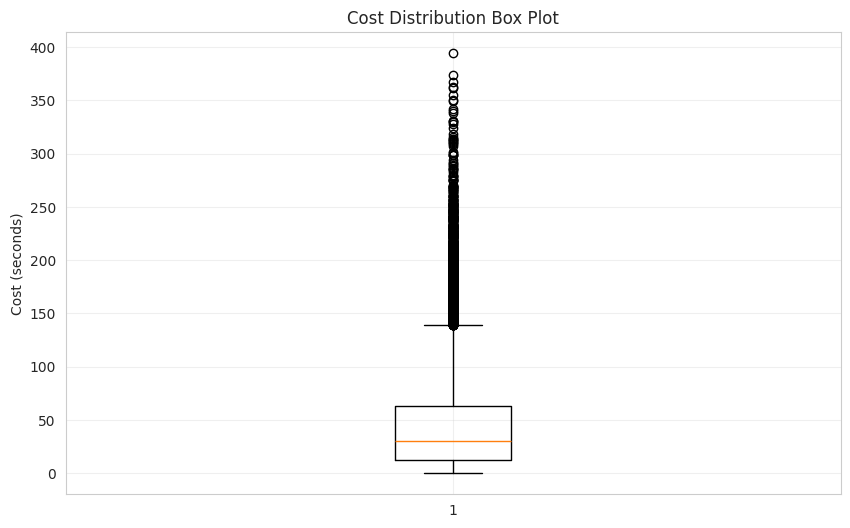

In [35]:
# Box plot of costs
plt.figure(figsize=(10, 6))
plt.boxplot(shortcuts_sample['cost'], vert=True)
plt.ylabel('Cost (seconds)')
plt.title('Cost Distribution Box Plot')
plt.grid(True, alpha=0.3)
plt.show()

## 4. Top Shortest and Longest Paths

In [36]:
# Top 10 shortest paths
print("Top 10 Shortest Paths:")
print("=" * 80)
shortcuts_df.orderBy("cost").select(
    "incoming_edge", "outgoing_edge", "via_edge", "cost"
).show(10, truncate=False)

Top 10 Shortest Paths:
+--------------------------+--------------------------+--------------------------+--------------------+
|incoming_edge             |outgoing_edge             |via_edge                  |cost                |
+--------------------------+--------------------------+--------------------------+--------------------+
|(12994514536, 12994514519)|(12994514519, 12994514536)|(12994514519, 12994514536)|0.013959999999999998|
|(12994514519, 12994514536)|(12994514536, 12994514519)|(12994514536, 12994514519)|0.013959999999999998|
|(12994514519, 12994514536)|(12994514536, 12994514537)|(12994514536, 12994514537)|0.013959999999999998|
|(12994514536, 12994514519)|(12994514519, 12994514522)|(12994514519, 12994514522)|0.013959999999999998|
|(12994514536, 12994514519)|(12994514519, 12994514518)|(12994514519, 12994514518)|0.013959999999999998|
|(12994514519, 12994514536)|(12994514536, 12994514525)|(12994514536, 12994514525)|0.013959999999999998|
|(1190365166, 8627217601)  |(8627217601, 

In [15]:
# Top 10 longest paths
print("Top 10 Longest Paths:")
print("=" * 80)
shortcuts_df.orderBy(F.desc("cost")).select(
    "incoming_edge", "outgoing_edge", "via_edge", "cost"
).show(10, truncate=False)

Top 10 Longest Paths:
+-----------------------+------------------------+------------------------+------------------+
|incoming_edge          |outgoing_edge           |via_edge                |cost              |
+-----------------------+------------------------+------------------------+------------------+
|(1127151355, 524512131)|(633796156, 633796184)  |(335742826, 633796152)  |405.12210500000003|
|(1127151355, 524512131)|(633796146, 633796140)  |(633796140, 633796146)  |403.160775        |
|(1127151355, 524512131)|(633796146, 633796173)  |(633796140, 633796146)  |403.160775        |
|(1127151355, 524512131)|(633796152, 335742826)  |(335742826, 633796152)  |402.59675500000003|
|(1127151355, 524512131)|(431372684, 633796140)  |(633796140, 431372684)  |402.237775        |
|(1127151355, 524512131)|(633796140, 431372684)  |(1127151355, 524512131) |400.594375        |
|(1127151355, 524512131)|(633796140, 633796146)  |(1127151355, 524512131) |400.594375        |
|(1127151355, 524512131)|(43

## 5. Edge Connectivity Analysis

In [16]:
# Outgoing paths per edge (how many destinations each edge can reach)
outgoing_per_edge = shortcuts_df.groupBy("incoming_edge") \
    .agg(
        F.count("*").alias("num_destinations"),
        F.avg("cost").alias("avg_cost_to_destinations")
    ) \
    .orderBy(F.desc("num_destinations"))

print("Top 10 Edges by Number of Reachable Destinations:")
outgoing_per_edge.show(10)

Top 10 Edges by Number of Reachable Destinations:
+--------------------+----------------+------------------------+
|       incoming_edge|num_destinations|avg_cost_to_destinations|
+--------------------+----------------+------------------------+
|(2007669691, 6337...|            1095|      112.08074915591006|
|(431380767, 63379...|            1095|        96.5581707266863|
|(431372705, 33574...|            1095|      106.03544798677578|
|(431372705, 20076...|            1093|       99.92083396275524|
|(654495632, 10302...|            1078|       89.81770033689666|
|(1030241753, 1030...|            1078|      101.74290115743975|
|(1030241753, 1030...|            1078|      101.62796657487947|
|(8863776948, 4161...|            1072|       87.35096326481097|
|(416104703, 41611...|            1072|       89.39500472936318|
|(347333355, 43137...|            1072|       88.23644856642785|
+--------------------+----------------+------------------------+
only showing top 10 rows


In [17]:
# Incoming paths per edge (how many sources can reach each edge)
incoming_per_edge = shortcuts_df.groupBy("outgoing_edge") \
    .agg(
        F.count("*").alias("num_sources"),
        F.avg("cost").alias("avg_cost_from_sources")
    ) \
    .orderBy(F.desc("num_sources"))

print("Top 10 Edges by Number of Incoming Sources:")
incoming_per_edge.show(10)

Top 10 Edges by Number of Incoming Sources:
+--------------------+-----------+---------------------+
|       outgoing_edge|num_sources|avg_cost_from_sources|
+--------------------+-----------+---------------------+
|(335742826, 43137...|       1097|   103.04595060796466|
|(633796184, 43138...|       1097|   103.55499134938064|
|(633796184, 20076...|       1097|    103.5329869191163|
|(2007669909, 4313...|       1095|   104.90414706439148|
|(12854592269, 504...|       1082|     92.4999592707808|
|(633796436, 92794...|       1080|    90.62352866140576|
|(320018371, 55001...|       1077|    96.93618566479559|
|(335609751, 55001...|       1077|    97.54242350756873|
|(320018371, 11382...|       1077|    96.94623340852816|
|(1030241787, 1030...|       1076|   107.26860398480626|
+--------------------+-----------+---------------------+
only showing top 10 rows


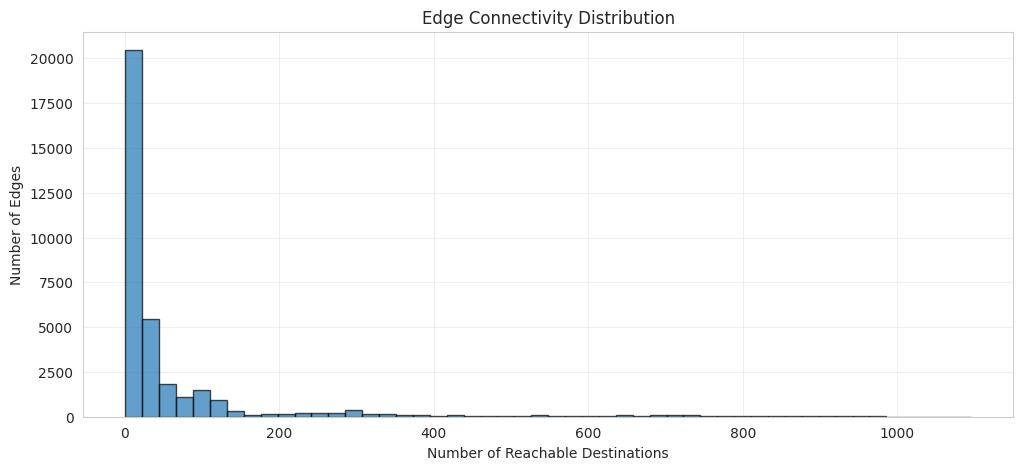

Average destinations per edge: 63.84
Median destinations per edge: 16.00


In [18]:
# Distribution of connectivity
connectivity_stats = outgoing_per_edge.select("num_destinations").toPandas()

plt.figure(figsize=(12, 5))
plt.hist(connectivity_stats['num_destinations'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Number of Reachable Destinations')
plt.ylabel('Number of Edges')
plt.title('Edge Connectivity Distribution')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Average destinations per edge: {connectivity_stats['num_destinations'].mean():.2f}")
print(f"Median destinations per edge: {connectivity_stats['num_destinations'].median():.2f}")

## 6. Via Edge Analysis

In [19]:
# Most frequently used via edges (important intermediate edges)
via_edge_usage = shortcuts_df.groupBy("via_edge") \
    .agg(F.count("*").alias("usage_count")) \
    .orderBy(F.desc("usage_count"))

print("Top 20 Most Frequently Used Via Edges (Critical Junctions):")
via_edge_usage.show(20)

Top 20 Most Frequently Used Via Edges (Critical Junctions):
+--------------------+-----------+
|            via_edge|usage_count|
+--------------------+-----------+
|(345177913, 75237...|      16695|
|(8809940437, 4625...|      12816|
|(12653337133, 465...|       7739|
|(3432790457, 4899...|       7315|
|(8398962763, 8840...|       7232|
|(346137291, 13168...|       6994|
|(416105048, 41611...|       6824|
|(416105316, 31168...|       5978|
|(558662885, 25363...|       5833|
|(5310909120, 2503...|       5573|
|(412703804, 57593...|       5438|
|(8374175125, 9569...|       5381|
|(5326882723, 1030...|       5009|
|(431379908, 43137...|       4690|
|(558662655, 55866...|       4518|
|(346237409, 59839...|       4505|
|(431381142, 15643...|       4394|
|(9051279328, 3539...|       4350|
|(11267662819, 113...|       4263|
|(431381887, 43138...|       4220|
+--------------------+-----------+
only showing top 20 rows


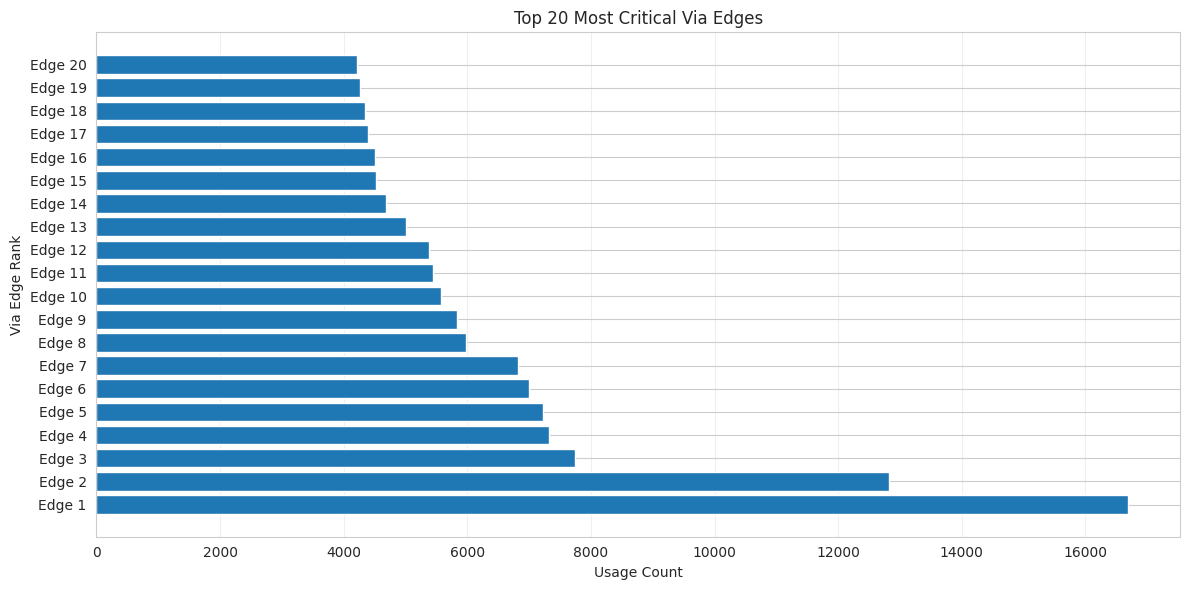

In [20]:
# Visualize top via edges
top_via_edges = via_edge_usage.limit(20).toPandas()

plt.figure(figsize=(12, 6))
plt.barh(range(len(top_via_edges)), top_via_edges['usage_count'])
plt.yticks(range(len(top_via_edges)), [f"Edge {i+1}" for i in range(len(top_via_edges))])
plt.xlabel('Usage Count')
plt.ylabel('Via Edge Rank')
plt.title('Top 20 Most Critical Via Edges')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## 7. Cost Percentiles

In [21]:
# Calculate various percentiles
percentiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
percentile_values = shortcuts_df.select(
    *[F.expr(f"percentile_approx(cost, {p})").alias(f"p{int(p*100)}") for p in percentiles]
).toPandas()

print("Cost Percentiles:")
print("=" * 60)
for p in percentiles:
    col_name = f"p{int(p*100)}"
    value = percentile_values[col_name].iloc[0]
    print(f"P{int(p*100):>2} (top {100-int(p*100):>2}%): {value:>8.2f} sec ({value/60:>6.2f} min)")

Cost Percentiles:
P10 (top 90%):     4.72 sec (  0.08 min)
P25 (top 75%):    12.97 sec (  0.22 min)
P50 (top 50%):    30.64 sec (  0.51 min)
P75 (top 25%):    63.54 sec (  1.06 min)
P90 (top 10%):   115.18 sec (  1.92 min)
P95 (top  5%):   150.01 sec (  2.50 min)
P99 (top  1%):   216.59 sec (  3.61 min)


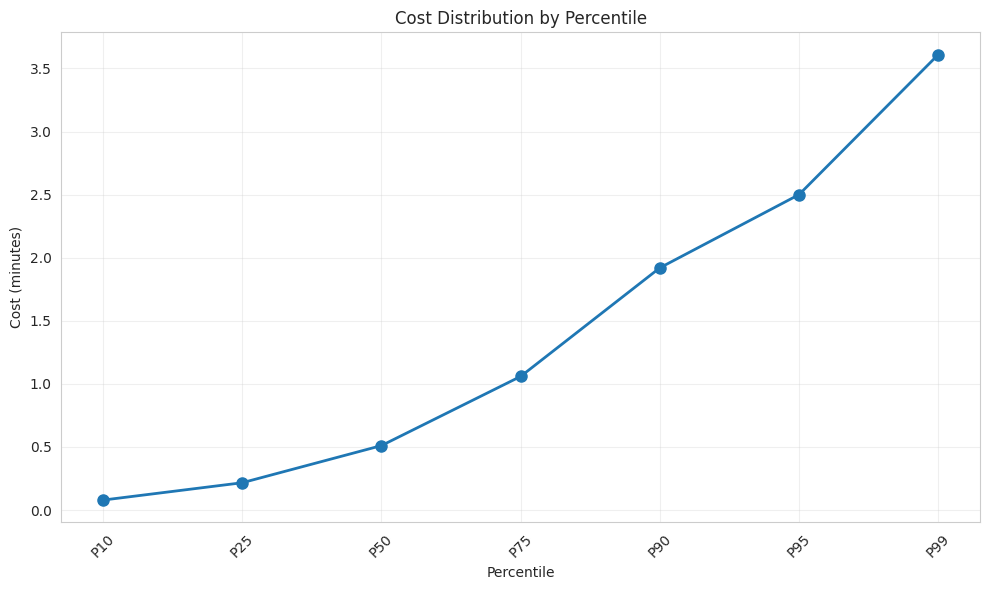

In [22]:
# Visualize percentiles
percentile_df = pd.DataFrame({
    'Percentile': [f"P{int(p*100)}" for p in percentiles],
    'Cost (minutes)': [percentile_values[f"p{int(p*100)}"].iloc[0] / 60 for p in percentiles]
})

plt.figure(figsize=(10, 6))
plt.plot(percentile_df['Percentile'], percentile_df['Cost (minutes)'], marker='o', linewidth=2, markersize=8)
plt.xlabel('Percentile')
plt.ylabel('Cost (minutes)')
plt.title('Cost Distribution by Percentile')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 8. Direct vs Multi-hop Paths

In [23]:
# Identify direct paths (where via_edge equals incoming_edge)
direct_paths = shortcuts_df.filter(F.col("via_edge") == F.col("incoming_edge"))
multi_hop_paths = shortcuts_df.filter(F.col("via_edge") != F.col("incoming_edge"))

direct_count = direct_paths.count()
multi_hop_count = multi_hop_paths.count()
total_count = shortcuts_df.count()

print(f"Direct paths: {direct_count:,} ({direct_count/total_count*100:.2f}%)")
print(f"Multi-hop paths: {multi_hop_count:,} ({multi_hop_count/total_count*100:.2f}%)")

# Average costs
direct_avg_cost = direct_paths.agg(F.avg("cost")).collect()[0][0]
multi_hop_avg_cost = multi_hop_paths.agg(F.avg("cost")).collect()[0][0]

print(f"\nAverage cost of direct paths: {direct_avg_cost:.2f} sec")
print(f"Average cost of multi-hop paths: {multi_hop_avg_cost:.2f} sec")

Direct paths: 232,887 (10.50%)
Multi-hop paths: 1,985,703 (89.50%)

Average cost of direct paths: 22.68 sec
Average cost of multi-hop paths: 49.79 sec


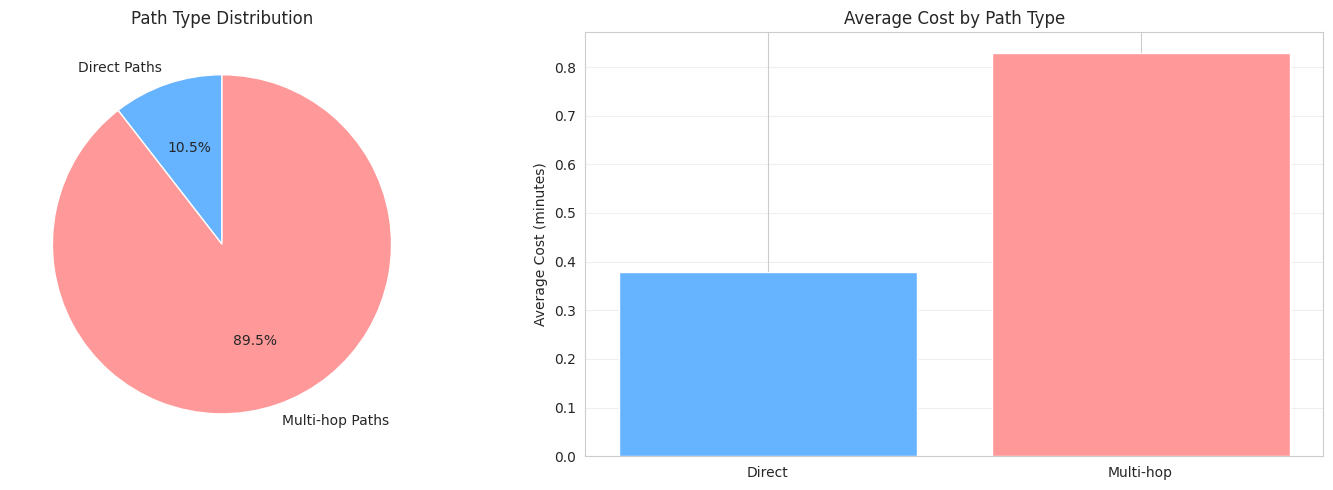

In [24]:
# Visualize direct vs multi-hop
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Pie chart
axes[0].pie(
    [direct_count, multi_hop_count],
    labels=['Direct Paths', 'Multi-hop Paths'],
    autopct='%1.1f%%',
    startangle=90,
    colors=['#66b3ff', '#ff9999']
)
axes[0].set_title('Path Type Distribution')

# Bar chart for average costs
axes[1].bar(['Direct', 'Multi-hop'], [direct_avg_cost/60, multi_hop_avg_cost/60], color=['#66b3ff', '#ff9999'])
axes[1].set_ylabel('Average Cost (minutes)')
axes[1].set_title('Average Cost by Path Type')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 9. Export Summary Statistics

In [25]:
# Create summary report
summary = {
    'Total Shortcuts': total_count,
    'Unique Edges': unique_incoming,
    'Direct Paths': direct_count,
    'Multi-hop Paths': multi_hop_count,
    'Min Cost (sec)': cost_stats['min_cost'].iloc[0],
    'Max Cost (sec)': cost_stats['max_cost'].iloc[0],
    'Avg Cost (sec)': cost_stats['avg_cost'].iloc[0],
    'Median Cost (sec)': cost_stats['median_cost'].iloc[0],
    'P95 Cost (sec)': cost_stats['p95_cost'].iloc[0]
}

summary_df = pd.DataFrame([summary]).T
summary_df.columns = ['Value']

print("\nSummary Statistics:")
print("=" * 60)
print(summary_df.to_string())

# Save to CSV
summary_df.to_csv('../output/shortcuts_summary.csv')
print("\n✓ Summary saved to: ../output/shortcuts_summary.csv")


Summary Statistics:
                          Value
Total Shortcuts    2.218590e+06
Unique Edges       3.475100e+04
Direct Paths       2.328870e+05
Multi-hop Paths    1.985703e+06
Min Cost (sec)     1.396000e-02
Max Cost (sec)     4.051221e+02
Avg Cost (sec)     4.694007e+01
Median Cost (sec)  3.063530e+01
P95 Cost (sec)     1.500100e+02

✓ Summary saved to: ../output/shortcuts_summary.csv


## 10. Cleanup

In [26]:
# Stop Spark session
spark.stop()
print("Spark session stopped.")

Spark session stopped.
